In [65]:
# project configurations

import sqlalchemy as sa
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import datetime
import os
import zipfile
import uuid
import matplotlib
import seaborn as sns
from os.path import basename
from datetime import datetime, date, time, timedelta
import math


client_pg = sa.create_engine('postgresql://localhost:5432/postgres')

In [3]:
# convert all transaction to USD 
query_all_transactions_with_amount_equivalent_to_USD = """
    WITH processed_transactions_with_usd_amount AS (
        (select ((t.amount / power(10, cd.exponent)) * fx.rate) AS amount_in_dollars, t.id, t.created_date, t.state, t.currency, t.merchant_country, t. merchant_category, t.type, t.entry_method, t.source, t.user_id
         from transactions t
                  JOIN fx_rates fx ON (fx.ccy = t.currency AND fx.base_ccy = 'USD')
                  JOIN currency_details cd ON cd.currency = t.currency
           and t.currency != 'USD')
        union
        (SELECT (t.amount / power(10, cd.exponent)) as amount_in_dollars, t.id, t.created_date, t.state, t.currency, t.merchant_country, t. merchant_category, t.type, t.entry_method, t.source, t.user_id
         from transactions t
                  join currency_details cd ON cd.currency = t.currency
           and t.currency = 'USD')
        order by created_date asc
    )
    select * from processed_transactions_with_usd_amount order by created_date asc;
"""
df_trx_in_usd = pd.read_sql(query_all_transactions_with_amount_equivalent_to_USD, client_pg)

query_fraudulent_users = """
select user_id from fraudsters;
"""
df_fraudulent_users = pd.read_sql(query_fraudulent_users, client_pg)

# remove trx of fraudulent users
fraudulent_users_user_id = df_fraudulent_users.user_id.values
df_trx_in_usd_wo_frd_usr = df_trx_in_usd.loc[~df_trx_in_usd['user_id'].isin(fraudulent_users_user_id)]
df_trx_in_usd_wo_frd_usr['amount_in_dollars'] = df_trx_in_usd_wo_frd_usr.amount_in_dollars.round()
df_trx_in_usd_wo_frd_usr.head()

# # clean data
df_trx_in_usd_wo_frd_usr = df_trx_in_usd_wo_frd_usr.fillna('null')
df_trx_in_usd_wo_frd_usr.head()

,amount_in_dollars,id,created_date,state,currency,merchant_country,merchant_category,type,entry_method,source,user_id
0,24.0,2602c6be-24ce-4d40-b2c9-935cfb5b8187,2015-03-03 11:55:44.233,COMPLETED,EUR,null,null,TOPUP,misc,OPHION,23dd04f8-28c8-490c-9a69-2cdffa1e0111
1,6.0,ebf2408d-edab-4bb8-9d36-588d310bf031,2015-03-05 11:33:43.964,COMPLETED,EUR,null,null,P2P,misc,INTERNAL,23dd04f8-28c8-490c-9a69-2cdffa1e0111
2,1.0,0a0cbf97-8022-443b-b3cc-0e4e6a43fdb9,2015-04-28 20:17:15.363,COMPLETED,GBP,null,null,P2P,misc,INTERNAL,73220926-b8eb-405a-90b8-1d770dfb41ec
3,13.0,078cdfdd-e42d-447a-8e93-63a87fa5c75b,2015-04-28 20:28:19.259,COMPLETED,GBP,null,null,TOPUP,misc,NYX,73220926-b8eb-405a-90b8-1d770dfb41ec
4,13.0,9db726bf-84cc-4712-b5dc-31f25348fb6d,2015-04-28 20:56:28.298,COMPLETED,GBP,null,null,P2P,misc,INTERNAL,73220926-b8eb-405a-90b8-1d770dfb41ec


In [5]:
# find out distribution of dollar value being transacted
# hist_all = df_trx_in_usd_wo_frd_usr['amount_in_dollars']
# sns.distplot(hist_all, kde=False, rug=True)

# distribution of dollar value being transacted for TOP_UP
hist_tp = df_trx_in_usd_wo_frd_usr.loc[df_trx_in_usd_wo_frd_usr['type'] == "TOPUP",['amount_in_dollars']]
# sns.distplot(hist_tp, kde=False, rug=True)

In [6]:
df_trx_in_usd_wo_frd_usr['amount_in_dollars'].describe()

# count    674108.000000
# mean         99.017786
# std        1010.287566
# min           0.000000
# 25%           5.000000
# 50%          15.000000
# 75%          56.000000
# max      186934.000000
# Name: amount_in_dollars, dtype: float64

hist_tp.describe()
# count	128769.000000
# mean	258.824694
# std	1352.703165
# min	0.000000
# 25%	13.000000
# 50%	66.000000
# 75%	235.000000
# max	164121.000000

,amount_in_dollars
count,128769.000000
mean,258.824694
std,1352.703165
min,0.000000
25%,13.000000
50%,66.000000
75%,235.000000
max,164121.000000


In [53]:
# users' w/ top up amount below median and above 50k trxs
df_usrs_tp_abv_50_eq_med = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['user_id'].isin(usrs_tp)) &(df_trx_in_usd_wo_frd_usr['type'] == 'TOPUP')]
df_usrs_tp_abv_50_eq_med.head()

df_usrs_tp_abv_50_eq_med_sorted = df_usrs_tp_abv_50_eq_med.sort_values(by=['user_id', 'created_date'], ascending=True)

df_usrs_tp_abv_50_eq_med_sorted['time_diff'] = df_usrs_tp_abv_50_eq_med_sorted.created_date.diff()
df_usrs_tp_abv_50_eq_med_sorted.loc[df_usrs_tp_abv_50_eq_med_sorted.user_id != df_usrs_tp_abv_50_eq_med_sorted.user_id.shift(), 'time_diff'] = pd.Timedelta(seconds=0)
df_usrs_tp_abv_50_eq_med_sorted = df_usrs_tp_abv_50_eq_med_sorted.sort_values('created_date')
# df_usrs_tp_abv_50_eq_med_sorted.time_diff = df_usrs_tp_abv_50_eq_med_sorted.time_diff.dt.round('d')
# df_usrs_tp_abv_50_eq_med_sorted.time_diff = df_usrs_tp_abv_50_eq_med_sorted.time_diff.dt.days


df_usrs_tp_abv_50_eq_med_sorted.head()

,amount_in_dollars,id,created_date,state,currency,merchant_country,merchant_category,type,entry_method,source,user_id,time_diff
244,26.0,84add187-eb79-47d3-8b0f-c16fea755f9a,2015-08-09 10:42:38.904,COMPLETED,GBP,null,null,TOPUP,misc,NYX,3f6bb28c-f945-4027-9178-747956c3ea58,0 days 00:00:00
1625,132.0,4e844579-477a-431a-aebc-2b1efa9e3290,2015-09-25 11:34:36.473,COMPLETED,GBP,null,null,TOPUP,misc,NYX,3f6bb28c-f945-4027-9178-747956c3ea58,47 days 00:51:57.569000
1734,660.0,4cdf4454-8f39-48b0-be64-9fbee542f19d,2015-09-28 12:37:39.021,COMPLETED,GBP,null,null,TOPUP,misc,NYX,3f6bb28c-f945-4027-9178-747956c3ea58,3 days 01:03:02.548000
1843,660.0,14cd6f9c-d02c-4ee6-a258-0d12c4ee7529,2015-10-02 07:07:08.200,COMPLETED,GBP,null,null,TOPUP,misc,NYX,3f6bb28c-f945-4027-9178-747956c3ea58,3 days 18:29:29.179000
1940,660.0,a2ec0212-b26e-49f6-9937-31a0f76e11de,2015-10-05 14:34:01.044,COMPLETED,GBP,null,null,TOPUP,misc,NYX,3f6bb28c-f945-4027-9178-747956c3ea58,3 days 07:26:52.844000


In [55]:
# print(df_usrs_tp_abv_50_eq_med_sorted.describe())

df_usrs_tp_abv_50_eq_med_sorted.loc[df_usrs_tp_abv_50_eq_med_sorted['user_id'] == uuid.UUID('3f6bb28c-f945-4027-9178-747956c3ea58')].sort_values('amount_in_dollars', ascending=False).head()

,amount_in_dollars,id,created_date,state,currency,merchant_country,merchant_category,type,entry_method,source,user_id,time_diff
26660,131991.0,96924e4f-e430-4764-8fc3-9c4afec74792,2016-07-20 10:14:16.775,FAILED,GBP,null,null,TOPUP,misc,HERA,3f6bb28c-f945-4027-9178-747956c3ea58,0 days 00:01:21.335000
26667,65995.0,542b4c53-574d-4c95-8221-0fe9804be2a7,2016-07-20 11:02:05.163,COMPLETED,GBP,null,null,TOPUP,misc,HERA,3f6bb28c-f945-4027-9178-747956c3ea58,0 days 00:00:28.502000
26665,65995.0,66064445-320b-4359-942b-b21c369461d1,2016-07-20 11:01:36.661,COMPLETED,GBP,null,null,TOPUP,misc,HERA,3f6bb28c-f945-4027-9178-747956c3ea58,0 days 00:47:19.886000
24442,10559.0,e65f08c0-48f5-43e6-9e11-2d16e1cceeea,2016-07-08 18:16:30.796,COMPLETED,GBP,null,null,TOPUP,misc,NYX,3f6bb28c-f945-4027-9178-747956c3ea58,10 days 06:03:06.601000
149724,4620.0,0448e779-d45f-4a1e-8316-8c1b2ec2c655,2017-07-26 06:28:48.375,COMPLETED,GBP,null,null,TOPUP,misc,HERA,3f6bb28c-f945-4027-9178-747956c3ea58,14 days 21:28:08.301000


In [4]:
# # find out users who've made top up transactions below the median and also significantly above the median
users_transacting_below_equal_median_tp = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['amount_in_dollars'] <= 66) & (df_trx_in_usd_wo_frd_usr['type'] == 'TOPUP'), 'user_id' ].tolist()

users_transacting_above_equal_50k_tp = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['amount_in_dollars']>= 50000) & (df_trx_in_usd_wo_frd_usr['type'] == 'TOPUP'), 'user_id' ].tolist()

# users_transacting_above_equal_100k_tp = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['amount_in_dollars']>= 100000) & (df_trx_in_usd_wo_frd_usr['type'] == 'TOPUP'), 'user_id' ].tolist()

usrs_tp = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['user_id'].isin(users_transacting_below_equal_median_tp)) & (df_trx_in_usd_wo_frd_usr['user_id'].isin(users_transacting_above_equal_50k_tp))].user_id.unique()

# print(usrs_tp)
# above 50k and below equal median
# [UUID('3f6bb28c-f945-4027-9178-747956c3ea58') --
#  UUID('1bf4860f-2f60-4d80-889e-a2854b857f6a')
#  UUID('686b0a44-ef3e-48eb-982e-8884dc6256e6')
#  UUID('2c77500f-ca63-4c07-9e8c-3d6b44af00eb')
#  UUID('8832384c-cce6-408d-882b-93677af25add')
#  UUID('887c1df0-0dd6-47c2-afbd-b25e0624458c') --
#  UUID('ebaa87bd-491f-4175-8aad-3f0560e1acc3')
#  UUID('ca743f59-9ead-40d8-ace4-00d86b9df1a4') --
#  UUID('114a849c-8d66-47e8-9f46-6f8ff9736519')]

In [28]:
# find out users who've made transactions below the median and also significantly above the median
users_transacting_below_equal_median = df_trx_in_usd_wo_frd_usr.loc[df_trx_in_usd_wo_frd_usr['amount_in_dollars'] <= 15, 'user_id' ].tolist()

users_transacting_above_equal_50k = df_trx_in_usd_wo_frd_usr.loc[df_trx_in_usd_wo_frd_usr['amount_in_dollars']>= 50000, 'user_id' ].tolist()

usrs = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['user_id'].isin(users_transacting_below_equal_median)) & (df_trx_in_usd_wo_frd_usr['user_id'].isin(users_transacting_above_equal_50k))].user_id.unique()

print(usrs)

# above 50k and below equal median
# [UUID('3f6bb28c-f945-4027-9178-747956c3ea58')
#  UUID('b616d55d-90ab-4107-b77b-8bea24fd22b5')
#  UUID('1bf4860f-2f60-4d80-889e-a2854b857f6a')
#  UUID('686b0a44-ef3e-48eb-982e-8884dc6256e6')
#  UUID('2c77500f-ca63-4c07-9e8c-3d6b44af00eb')
#  UUID('3c1aa14d-818a-474f-847f-3d24907dd1c7')
#  UUID('605452f6-e9ce-42ef-bbf4-71e47958dcee')
#  UUID('8832384c-cce6-408d-882b-93677af25add')
#  UUID('887c1df0-0dd6-47c2-afbd-b25e0624458c')
#  UUID('7f40760d-6855-4362-ac71-e817bae61d3a')
#  UUID('ebaa87bd-491f-4175-8aad-3f0560e1acc3')
#  UUID('ca743f59-9ead-40d8-ace4-00d86b9df1a4')
#  UUID('114a849c-8d66-47e8-9f46-6f8ff9736519')]

[UUID('3f6bb28c-f945-4027-9178-747956c3ea58')
 UUID('b616d55d-90ab-4107-b77b-8bea24fd22b5')
 UUID('1bf4860f-2f60-4d80-889e-a2854b857f6a')
 UUID('686b0a44-ef3e-48eb-982e-8884dc6256e6')
 UUID('2c77500f-ca63-4c07-9e8c-3d6b44af00eb')
 UUID('3c1aa14d-818a-474f-847f-3d24907dd1c7')
 UUID('605452f6-e9ce-42ef-bbf4-71e47958dcee')
 UUID('8832384c-cce6-408d-882b-93677af25add')
 UUID('887c1df0-0dd6-47c2-afbd-b25e0624458c')
 UUID('7f40760d-6855-4362-ac71-e817bae61d3a')
 UUID('ebaa87bd-491f-4175-8aad-3f0560e1acc3')
 UUID('ca743f59-9ead-40d8-ace4-00d86b9df1a4')
 UUID('114a849c-8d66-47e8-9f46-6f8ff9736519')]


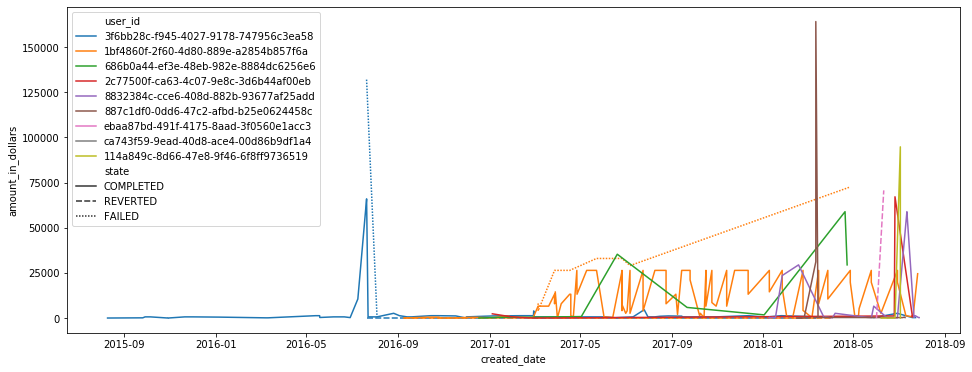

In [57]:
matplotlib.pyplot.figure(figsize=(16, 6))

sns.lineplot(x="created_date", y='amount_in_dollars', hue='user_id', style="state", data=df_usrs_tp_abv_50_eq_med_sorted)

sns.lineplot(x="time_diff", y='amount_in_dollars', hue='user_id', style="state", data=df_usrs_tp_abv_50_eq_med_sorted.loc[df_usrs_tp_abv_50_eq_med_sorted['time_diff'] <= 40])

sns.lineplot(x="time_diff", y='amount_in_dollars', hue='user_id', style="state", data=df_usrs_tp_abv_50_eq_med_sorted.loc[df_usrs_tp_abv_50_eq_med_sorted['time_diff'] <= 150])

sns.lineplot(x="time_diff", y='amount_in_dollars', hue='user_id', style="state", data=df_usrs_tp_abv_50_eq_med_sorted.loc[df_usrs_tp_abv_50_eq_med_sorted['time_diff'] >= 300])

sns.lineplot(x="time_diff", y='amount_in_dollars', hue='user_id', style="state", data=df_usrs_tp_abv_50_eq_med_sorted)

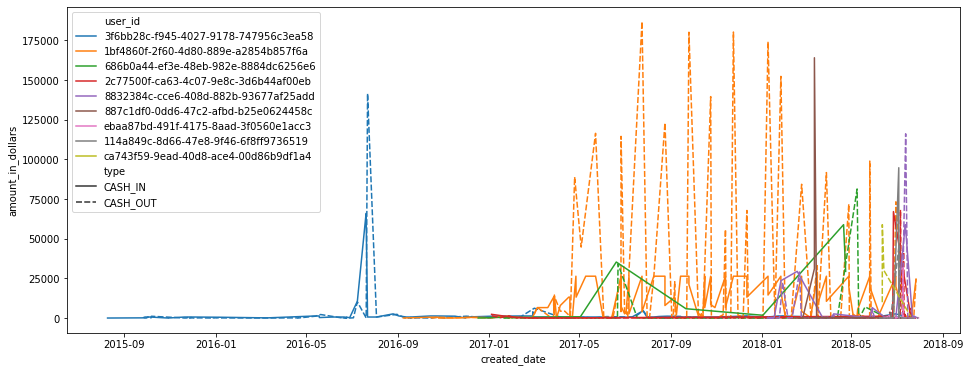

In [62]:
df_cf = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['user_id'].isin(users_transacting_below_equal_median)) & (df_trx_in_usd_wo_frd_usr['state'] == 'COMPLETED')]

df_cf.loc[df_cf['type'] != 'TOPUP', 'type'] = "CASH_OUT"
df_cf.loc[df_cf['type'] == 'TOPUP', 'type'] = "CASH_IN"

matplotlib.pyplot.figure(figsize=(16, 6))
sns.lineplot(x="created_date", y='amount_in_dollars', hue='user_id', style="type", data=df_cf)

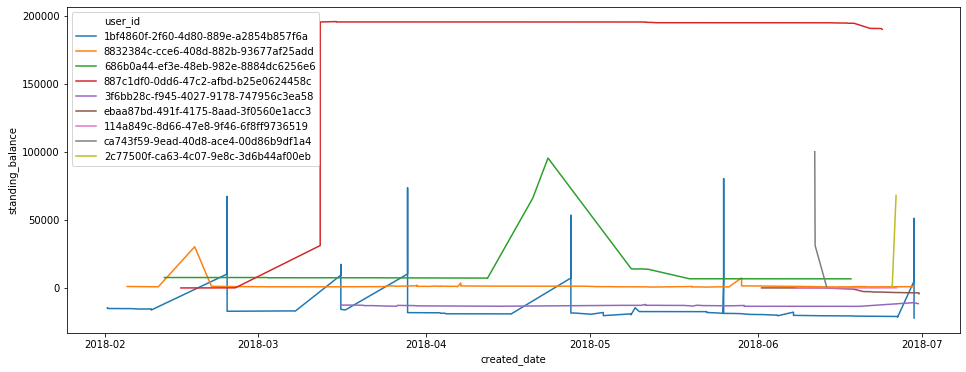

In [131]:
# matplotlib.pyplot.figure(figsize=(16, 6))
# sns.lineplot(x="created_date", y='amount_in_dollars', hue='user_id', style="type", data=df_cf[(df_cf['created_date'] <= '2018-07-01') & (df_cf['created_date'] >= '2018-02-01')])

matplotlib.pyplot.figure(figsize=(16, 6))
sns.lineplot(x="created_date", y='standing_balance', hue='user_id', data=df_new_standing_balance.loc[(df_new_standing_balance['created_date'] <= '2018-07-01') & (df_new_standing_balance['created_date'] >= '2018-02-01')])

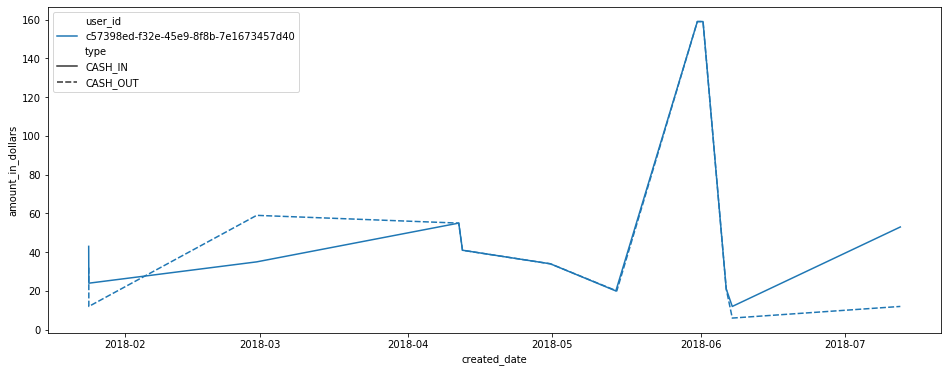

In [137]:
# median users
df_cf_med_usr = df_trx_in_usd_wo_frd_usr.loc[(df_trx_in_usd_wo_frd_usr['user_id'] == uuid.UUID('c57398ed-f32e-45e9-8f8b-7e1673457d40')) & (df_trx_in_usd_wo_frd_usr['state'] == 'COMPLETED')]

df_cf_med_usr.loc[df_cf_med_usr['type'] != 'TOPUP', 'type'] = "CASH_OUT"
df_cf_med_usr.loc[df_cf_med_usr['type'] == 'TOPUP', 'type'] = "CASH_IN"

matplotlib.pyplot.figure(figsize=(16, 6))
sns.lineplot(x="created_date", y='amount_in_dollars', hue='user_id', style="type", data=df_cf_med_usr)

In [116]:
# df_standing_balance.head()

# df_standing_balance[0:6].loc[df_standing_balance.user_id == df_standing_balance.user_id.shift()].head()

df_standing_balance.loc[df_standing_balance['user_id'] == uuid.UUID('2c77500f-ca63-4c07-9e8c-3d6b44af00eb')].head()

# df_standing_balance.columns.values

,amount_in_dollars,id,created_date,state,currency,merchant_country,merchant_category,type,entry_method,source,user_id,standing_balance
69098,2356.0,758d68ab-de2a-44ae-8bb9-77b03e19e7d8,2017-01-04 10:00:18.182,COMPLETED,EUR,null,null,CASH_IN,misc,OPHION,2c77500f-ca63-4c07-9e8c-3d6b44af00eb,2356.0
69180,1428.0,96abb654-f51d-4e50-908d-b2a3c18059f3,2017-01-04 15:06:40.382,COMPLETED,EUR,null,null,CASH_OUT,misc,CRONUS,2c77500f-ca63-4c07-9e8c-3d6b44af00eb,NaN
71926,224.0,9969be6d-5711-4c32-80f4-3c2bfbc21cd1,2017-01-15 10:07:21.507,COMPLETED,EUR,CHE,electronics_store,CASH_OUT,manu,GAIA,2c77500f-ca63-4c07-9e8c-3d6b44af00eb,NaN
75104,824.0,1cee5329-cc43-41d1-ad04-de4ad3180c79,2017-01-27 19:16:24.190,COMPLETED,EUR,null,null,CASH_IN,misc,OPHION,2c77500f-ca63-4c07-9e8c-3d6b44af00eb,NaN
75118,1434.0,fa285d57-80ed-415b-ab34-03c635c4fc5b,2017-01-27 19:40:30.053,COMPLETED,EUR,null,null,CASH_OUT,misc,CRONUS,2c77500f-ca63-4c07-9e8c-3d6b44af00eb,NaN


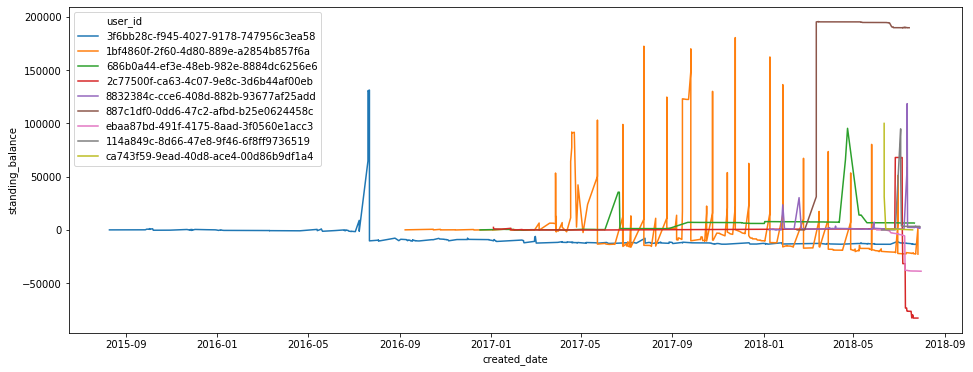

In [113]:
df_standing_balance = df_cf.sort_values(by=['user_id', 'created_date'], ascending=True)
df_standing_balance.loc[df_standing_balance.user_id != df_standing_balance.user_id.shift(), 'standing_balance'] = df_standing_balance['amount_in_dollars']

df_standing_balance = df_cf.sort_values(by=['user_id', 'created_date'], ascending=True)

df_standing_balance.loc[df_standing_balance.user_id != df_standing_balance.user_id.shift(), 'standing_balance'] = df_standing_balance['amount_in_dollars']

list_standing_balance_unique_user_id = df_standing_balance.user_id.unique()
list_new_standing_balance = []

for current_user_id in list_standing_balance_unique_user_id:
    current_user_id_standing_balance = df_standing_balance[df_standing_balance['user_id'] == current_user_id]
    list_current_user_id_standing_balance = current_user_id_standing_balance.values
    for index, current_trx in enumerate(list_current_user_id_standing_balance):
        if math.isnan(current_trx[11]):
            if current_trx[7] == 'CASH_IN':
                # print(list_current_user_id_standing_balance[index - 1][11] + current_trx[0])
                current_trx[11] = list_current_user_id_standing_balance[index - 1][11] + current_trx[0]
            elif current_trx[7] == 'CASH_OUT':
                # print(list_current_user_id_standing_balance[index - 1][11] - current_trx[0])
                current_trx[11] = list_current_user_id_standing_balance[index - 1][11] - current_trx[0]
        list_new_standing_balance.append(current_trx)

# print(list_new_standing_balance)

df_new_standing_balance = pd.DataFrame(list_new_standing_balance, columns=('amount_in_dollars', 'id', 'created_date', 'state', 'currency',
       'merchant_country', 'merchant_category', 'type', 'entry_method',
       'source', 'user_id', 'standing_balance'))

df_new_standing_balance = df_new_standing_balance.sort_values('created_date')

df_new_standing_balance.head()

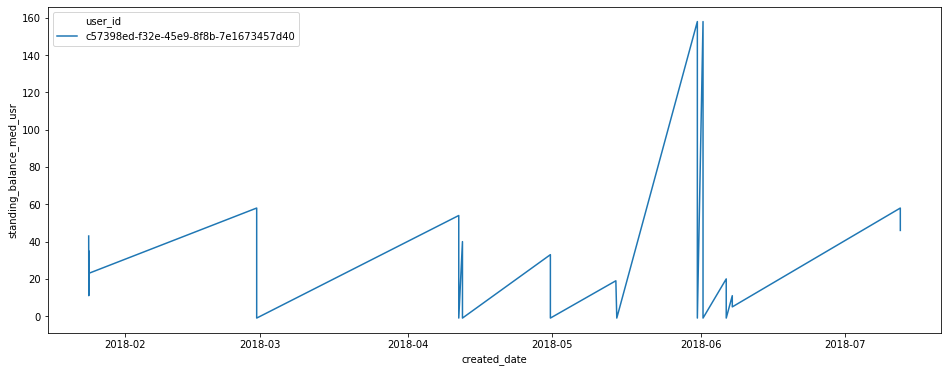

In [138]:
df_standing_balance_med_usr = df_cf_med_usr.sort_values(by=['user_id', 'created_date'], ascending=True)
df_standing_balance_med_usr.loc[df_standing_balance_med_usr.user_id != df_standing_balance_med_usr.user_id.shift(), 'standing_balance_med_usr'] = df_standing_balance_med_usr['amount_in_dollars']

df_standing_balance_med_usr = df_cf_med_usr.sort_values(by=['user_id', 'created_date'], ascending=True)

df_standing_balance_med_usr.loc[df_standing_balance_med_usr.user_id != df_standing_balance_med_usr.user_id.shift(), 'standing_balance_med_usr'] = df_standing_balance_med_usr['amount_in_dollars']

list_standing_balance_med_usr_unique_user_id = df_standing_balance_med_usr.user_id.unique()
list_new_standing_balance_med_usr = []

for current_user_id in list_standing_balance_med_usr_unique_user_id:
    current_user_id_standing_balance_med_usr = df_standing_balance_med_usr[df_standing_balance_med_usr['user_id'] == current_user_id]
    list_current_user_id_standing_balance_med_usr = current_user_id_standing_balance_med_usr.values
    for index, current_trx in enumerate(list_current_user_id_standing_balance_med_usr):
        if math.isnan(current_trx[11]):
            if current_trx[7] == 'CASH_IN':
                current_trx[11] = list_current_user_id_standing_balance_med_usr[index - 1][11] + current_trx[0]
            elif current_trx[7] == 'CASH_OUT':
                current_trx[11] = list_current_user_id_standing_balance_med_usr[index - 1][11] - current_trx[0]
        list_new_standing_balance_med_usr.append(current_trx)

df_new_standing_balance_med_usr = pd.DataFrame(list_new_standing_balance_med_usr, columns=('amount_in_dollars', 'id', 'created_date', 'state', 'currency',
       'merchant_country', 'merchant_category', 'type', 'entry_method',
       'source', 'user_id', 'standing_balance_med_usr'))

df_new_standing_balance_med_usr = df_new_standing_balance_med_usr.sort_values('created_date')

df_new_standing_balance_med_usr.head()

matplotlib.pyplot.figure(figsize=(16, 6))
sns.lineplot(x="created_date", y='standing_balance_med_usr', hue='user_id', data=df_new_standing_balance_med_usr)

In [139]:
df_new_standing_balance_med_usr.loc[df_new_standing_balance_med_usr['created_date'] > '2018-01-25'].head()

,amount_in_dollars,id,created_date,state,currency,merchant_country,merchant_category,type,entry_method,source,user_id,standing_balance_med_usr
4,35.0,a18abf56-54b3-4a90-89b1-15926e8cd59c,2018-02-28 09:54:10.280,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,58.0
5,59.0,7d50a950-90a1-4bbe-ad29-c9693ac5fb30,2018-02-28 09:54:55.633,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0
6,55.0,c08c274d-d2d7-4bce-a078-190f2fa83ae0,2018-04-11 13:15:08.668,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,54.0
7,55.0,a63a8553-4c8d-464e-87d2-5b0ac7f6e89c,2018-04-11 13:18:38.684,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0
8,41.0,9b386542-dee6-450a-922b-3fbde2a7d66a,2018-04-12 07:48:32.489,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,40.0


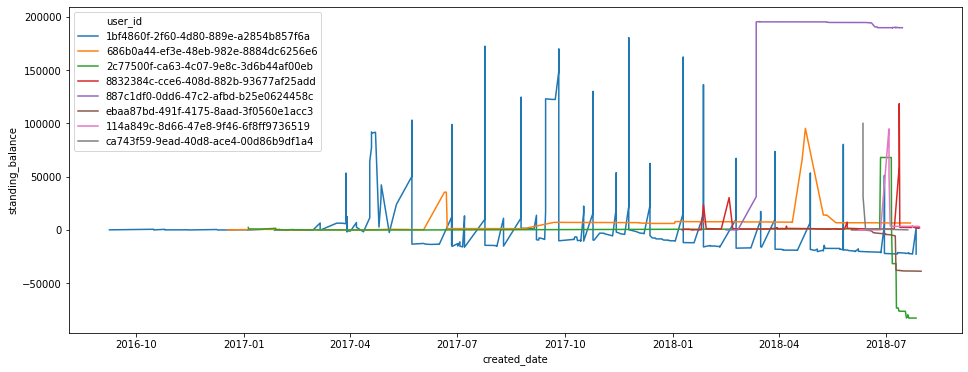

In [117]:
matplotlib.pyplot.figure(figsize=(16, 6))
sns.lineplot(x="created_date", y='standing_balance', hue='user_id', data=df_new_standing_balance.loc[df_new_standing_balance['user_id'] != uuid.UUID('3f6bb28c-f945-4027-9178-747956c3ea58')])

In [140]:
df_new_standing_balance_med_usr.loc[(df_new_standing_balance_med_usr['user_id'] == uuid.UUID('c57398ed-f32e-45e9-8f8b-7e1673457d40')) & (df_new_standing_balance_med_usr['created_date'] >= '2018-02-01')]

,amount_in_dollars,id,created_date,state,currency,merchant_country,merchant_category,type,entry_method,source,user_id,standing_balance_med_usr
4,35.0,a18abf56-54b3-4a90-89b1-15926e8cd59c,2018-02-28 09:54:10.280,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,58.0
5,59.0,7d50a950-90a1-4bbe-ad29-c9693ac5fb30,2018-02-28 09:54:55.633,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0
6,55.0,c08c274d-d2d7-4bce-a078-190f2fa83ae0,2018-04-11 13:15:08.668,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,54.0
7,55.0,a63a8553-4c8d-464e-87d2-5b0ac7f6e89c,2018-04-11 13:18:38.684,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0
8,41.0,9b386542-dee6-450a-922b-3fbde2a7d66a,2018-04-12 07:48:32.489,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,40.0
9,41.0,d8c65f75-e4bc-4644-963d-5430498aef4e,2018-04-12 07:50:18.628,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0
10,34.0,fd803219-958c-439d-b7ba-5b5914f33b13,2018-04-30 15:49:18.091,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,33.0
11,34.0,008c6bd1-adec-418b-89b5-09c308e3fb08,2018-04-30 15:50:20.098,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0
12,20.0,0fac29d0-d0e8-4e09-bcb8-e77f1509a5dd,2018-05-14 07:30:54.777,COMPLETED,EUR,null,null,CASH_IN,misc,HERA,c57398ed-f32e-45e9-8f8b-7e1673457d40,19.0
13,20.0,7e35d7cf-12cd-4270-b52e-7ac40a57972a,2018-05-14 12:08:07.163,COMPLETED,EUR,null,null,CASH_OUT,misc,LETO,c57398ed-f32e-45e9-8f8b-7e1673457d40,-1.0


In [ ]:
# 3f6bb28c-f945-4027-9178-747956c3ea58
# 887c1df0-0dd6-47c2-afbd-b25e0624458c
# ca743f59-9ead-40d8-ace4-00d86b9df1a4
# 686b0a44-ef3e-48eb-982e-8884dc6256e6
# 8832384c-cce6-408d-882b-93677af25add



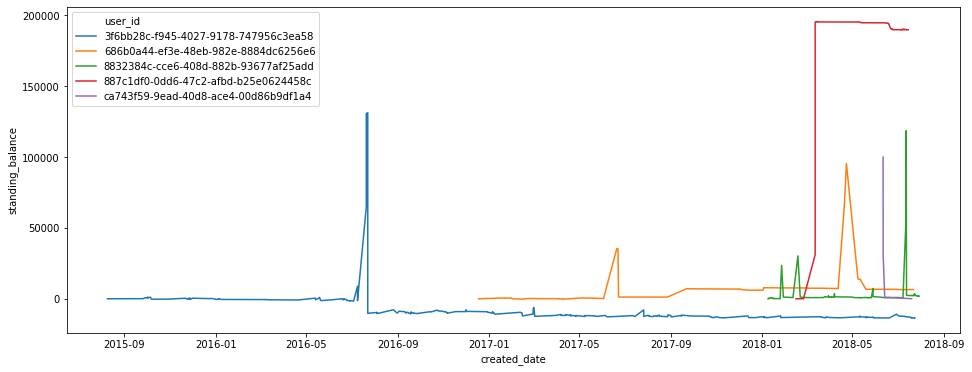

In [145]:
# matplotlib.pyplot.figure(figsize=(16, 6))
# sns.lineplot(x="created_date", y='amount_in_dollars', hue='user_id', style="type", data=df_cf[(df_cf['created_date'] <= '2018-07-01') & (df_cf['created_date'] >= '2018-02-01')])

matplotlib.pyplot.figure(figsize=(16, 6))
sns.lineplot(x="created_date", y='standing_balance', hue='user_id', data=df_new_standing_balance.loc[(df_new_standing_balance['user_id'] == uuid.UUID('3f6bb28c-f945-4027-9178-747956c3ea58')) | (df_new_standing_balance['user_id'] == uuid.UUID('887c1df0-0dd6-47c2-afbd-b25e0624458c')) | (df_new_standing_balance['user_id'] == uuid.UUID('8832384c-cce6-408d-882b-93677af25add')) | (df_new_standing_balance['user_id'] == uuid.UUID('686b0a44-ef3e-48eb-982e-8884dc6256e6')) | (df_new_standing_balance['user_id'] == uuid.UUID('ca743f59-9ead-40d8-ace4-00d86b9df1a4'))])
